# Boundary layer in transition to turbulence

Jared Callaham (2020)

Here we study the Reynolds-averaged Navier-Stokes (RANS) equations.  Fields are obtained by averages of the DNS by Lee & Zaki available from the [Johns Hopkins turbulence database](http://turbulence.pha.jhu.edu/Transition_bl.aspx).
Average profiles can be downloaded [here](http://turbulence.pha.jhu.edu/docs/transition_bl/Transition_BL_Time_Averaged_Profiles.h5).
As for the cylinder wake, we focus on the streamwise component of the equations:
$$ \bar{u} \bar{u}_x + \bar{v} \bar{u}_y = \rho^{-1} \bar{p}_x + \nu \nabla^2 \bar{u}  - (\overline{u' v'})_y - (\overline{u'^2})_x $$
The main dominant balance physics we expect to see are in the inertial and viscous sublayers in the turbulent region, where the wall-normal Reynolds stress $(\overline{u' v'})_y$ is balanced by mean flow advection and viscosity, respectively.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import sklearn as sk
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
from scipy.io import loadmat
import h5py
from scipy import sparse, linalg
from scipy.optimize import curve_fit, root
from scipy.integrate import odeint
from scipy.interpolate import interp1d

import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('figure', figsize=(15, 3))
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
%config InlineBackend.figure_format = 'retina'

from matplotlib.colors import ListedColormap

# Seaborn colormap
import seaborn as sns
sns_list = sns.color_palette('deep').as_hex()
sns_list.insert(0, '#ffffff')  # Insert white at zero position
sns_cmap = ListedColormap(sns_list)

cm = sns_cmap

mpl_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
            '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
            '#bcbd22', '#17becf']

# Load and visualize data

In [2]:
file = h5py.File('./data/Transition_BL_Time_Averaged_Profiles.h5', 'r')

x = np.array(file['x_coor'])
y = np.array(file['y_coor'])
u = np.array(file['um'])
v = np.array(file['vm'])
p = np.array(file['pm'])
Ruu = np.array(file['uum']) - u**2
Ruv = np.array(file['uvm']) - u*v
Rvv = np.array(file['uvm']) - v**2

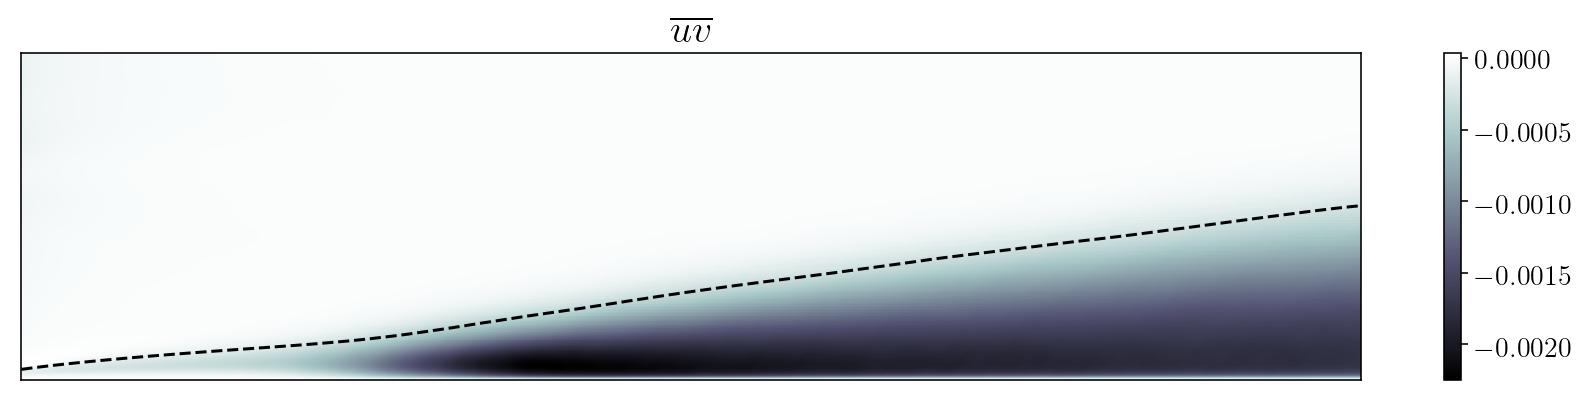

In [3]:
# Visualize by wall-normal Reynolds stress

X, Y = np.meshgrid(x, y)

# Include 99% isocontour of mean velocity
U_inf = 1
nu = 1/800  # Details in README-transition_bl.pdf
Re = (U_inf/nu)*x

plt.figure(figsize=(15, 3))
plt.pcolor(Re, y, Ruv, cmap='bone') #, vmin=0, vmax=1)
plt.colorbar()

plt.contour((U_inf/nu)*X, Y, u, [0.99], linestyles='dashed', colors='k')

plt.gca().set_yticks([])
plt.gca().set_xticks([])
plt.title(r'$\overline{uv}$')
plt.show()

### Finite difference derivatives to estimate gradients

__NOTE: VARIABLE STEP SIZE IN Y DIRECTION ONLY__

In [4]:
dx = x[1]-x[0]
dy = y[1:]-y[:-1]

nx = len(x)
ny = len(y)

Dy = sparse.diags( [-1, 1], [-1, 1], shape=(ny, ny) ).toarray()
# Second-order forward/backwards at boundaries
Dy[0, :3] = np.array([-3, 4, -1])
Dy[-1, -3:] = np.array([1, -4, 3])
for i in range(ny-1):
    Dy[i, :] = Dy[i, :]/(2*dy[i])
Dy[-1, :] = Dy[-1, :]/(2*dy[-1])

# Repeat for each x-location
Dy = sparse.block_diag([Dy for i in range(nx)])

Dx = sparse.diags( [-1, 1], [-ny, ny], shape=(nx*ny, nx*ny))
Dx = sparse.lil_matrix(Dx)
# Second-order forwards/backwards at boundaries
for i in range(ny):
    Dx[i, i] = -3
    Dx[i, ny+i] = 4
    Dx[i, 2*ny+i] = -1
    Dx[-(i+1), -(i+1)] = 3
    Dx[-(i+1), -(ny+i+1)] = -4
    Dx[-(i+1), -(2*ny+i+1)] = 1
Dx = Dx/(2*dx)

Dx = sparse.csr_matrix(Dx)
Dy = sparse.csr_matrix(Dy)

Dxx = 2*(Dx @ Dx)
Dyy = 2*(Dy @ Dy)

In [5]:
u = u.flatten('F')
v = v.flatten('F')
p = p.flatten('F')
Ruu = Ruu.flatten('F')
Ruv = Ruv.flatten('F')

ux = Dx @ u
uy = Dy @ u
vx = Dx @ v
vy = Dy @ v
px = Dx @ p
py = Dy @ p
lap_u = (Dxx + Dyy) @ u
Ruux = Dx @ Ruu
Ruvy = Dy @ Ruv

# 1. Equation space representation

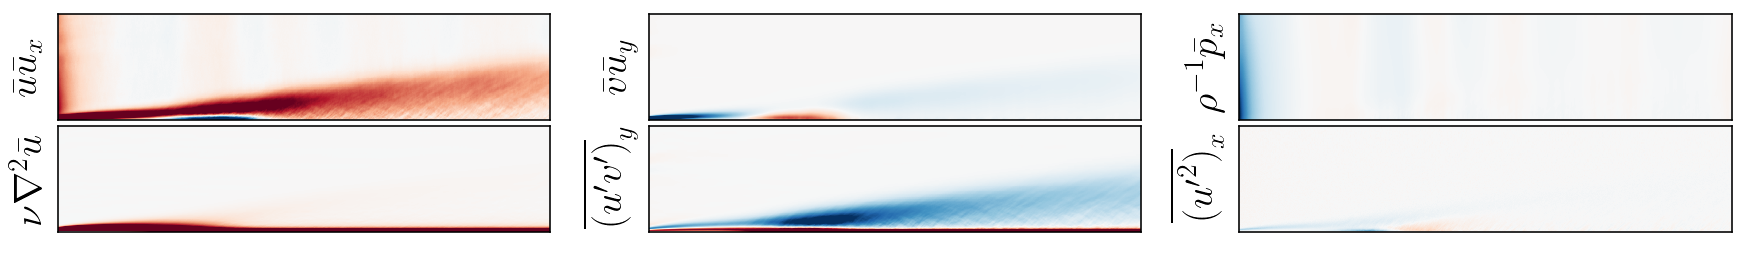

In [6]:
# Plot all six terms in the RANS equation
plt.figure(figsize=(15, 2))
labels = [r'$\bar{u} \bar{u}_x$', r'$\bar{v}\bar{u}_y$', r'$\rho^{-1} \bar{p}_x$',
          r'$\nu \nabla^2 \bar{u}$', r'$\overline{(u^\prime v^\prime)}_y$', r'$\overline{({u^\prime} ^2)}_x$']
clim = 5e-4
fontsize=20

plt.subplot(231)
field = np.reshape(u*ux, [ny, nx], order='F')
plt.pcolor(x, y, field, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.ylabel(labels[0], fontsize=fontsize)

plt.subplot(232)
field = np.reshape(v*uy, [ny, nx], order='F')
plt.pcolor(x, y, field, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.ylabel(labels[1], fontsize=fontsize)

plt.subplot(233)
field = np.reshape(px, [ny, nx], order='F')
plt.pcolor(x, y, field, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.ylabel(labels[2], fontsize=fontsize)

plt.subplot(234)
field = np.reshape(nu*lap_u, [ny, nx], order='F')
plt.pcolor(x, y, field, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.ylabel(labels[3], fontsize=fontsize)

plt.subplot(235)
field = np.reshape(Ruvy, [ny, nx], order='F')
plt.pcolor(x, y, field, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.ylabel(labels[4], fontsize=fontsize)

plt.subplot(236)
field = np.reshape(Ruux, [ny, nx], order='F')
plt.pcolor(x, y, field, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.ylabel(labels[5], fontsize=fontsize)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.05)

plt.show()

# 2. Gaussian mixture model

Since the data is very high resolution, train on 10% randomly subsampled points for better speed.

In [7]:
# Train Gaussian mixture model

 # Advection, pressure, viscous, Reynolds stresses
features = 1e3*np.vstack([u*ux, v*uy, px, nu*lap_u, Ruvy, Ruux]).T
nfeatures = features.shape[1]
        
# Fit Gaussian mixture model
nc = 6  # Number of clusters
seed = np.random.randint(2**32)
seed = 3696299933  #  Keep a seed for debugging/plotting
print(seed)
model = GaussianMixture(n_components=nc, random_state=seed)

# PERMUTATION
sample_pct = 0.1
mask = np.random.permutation(features.shape[0])[:int(sample_pct*features.shape[0])]
model.fit(features[mask, :])

3696299933


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=3696299933, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

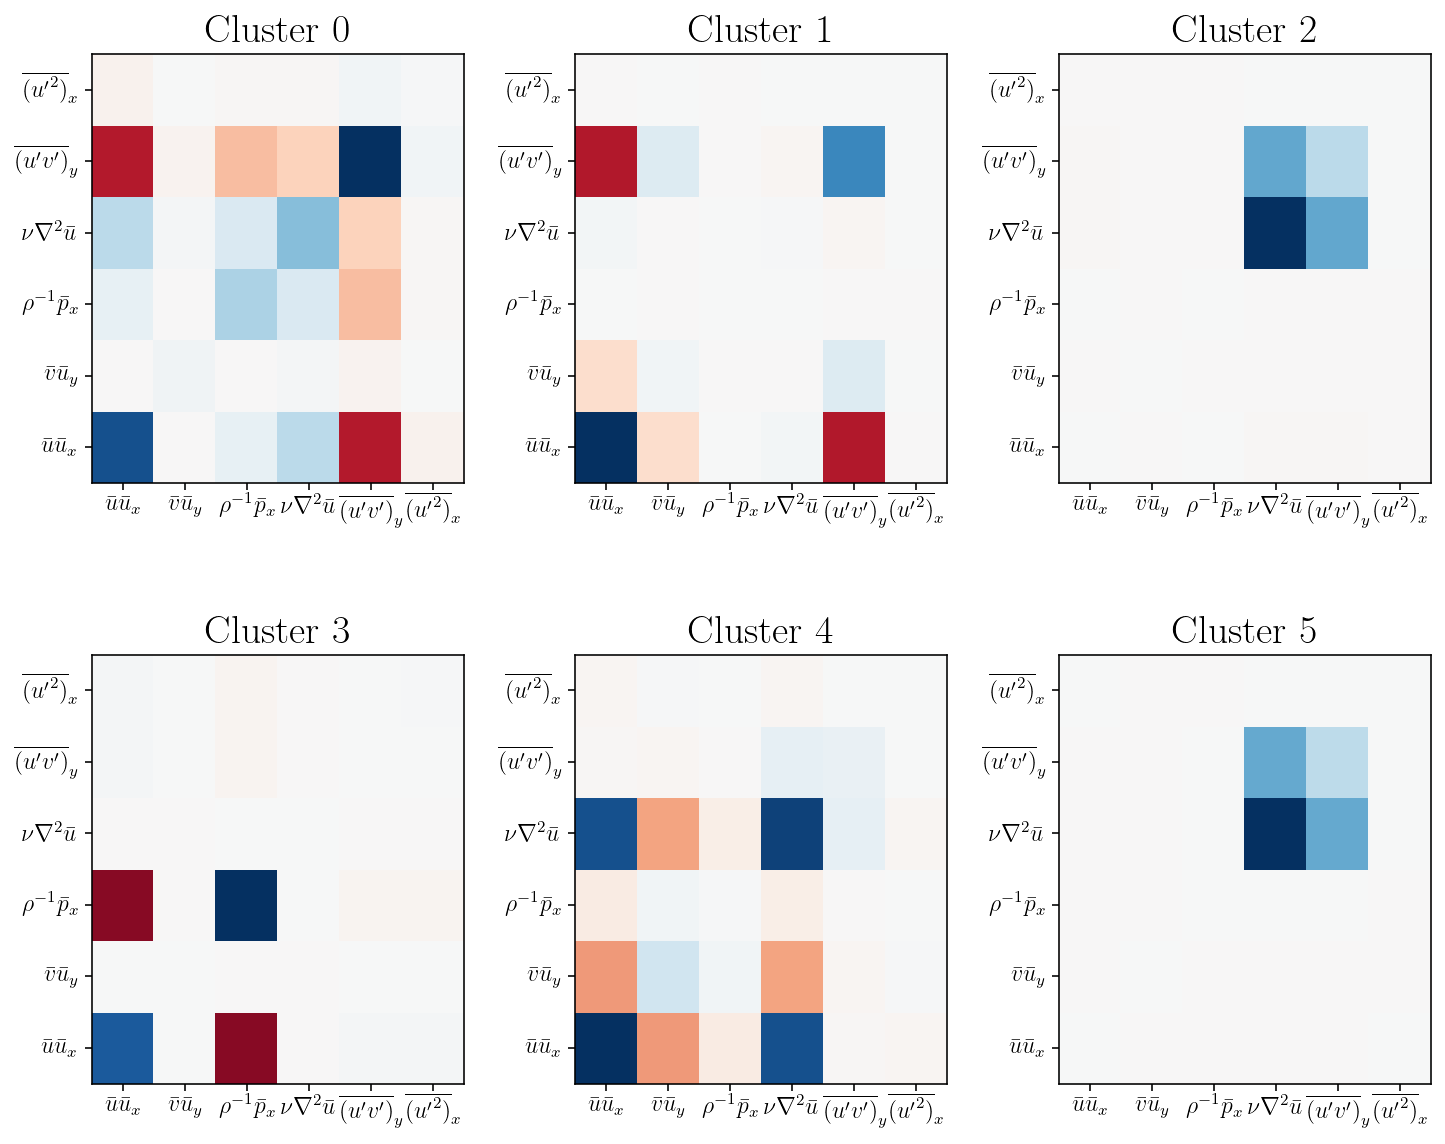

In [8]:
# Plot covariance matrices for the GMM
plt.figure(figsize=(12, 15))
for i in range(nc):
    plt.subplot(3, 3, i+1)
    C = model.covariances_[i, :, :]
    plt.pcolor(C, vmin=-max(abs(C.flatten())), vmax=max(abs(C.flatten())), cmap='RdBu')
    plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_xticklabels(labels, fontsize=12)
    plt.gca().set_yticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_yticklabels(labels, fontsize=12)
    plt.gca().set_title('Cluster {0}'.format(i))
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
plt.show()

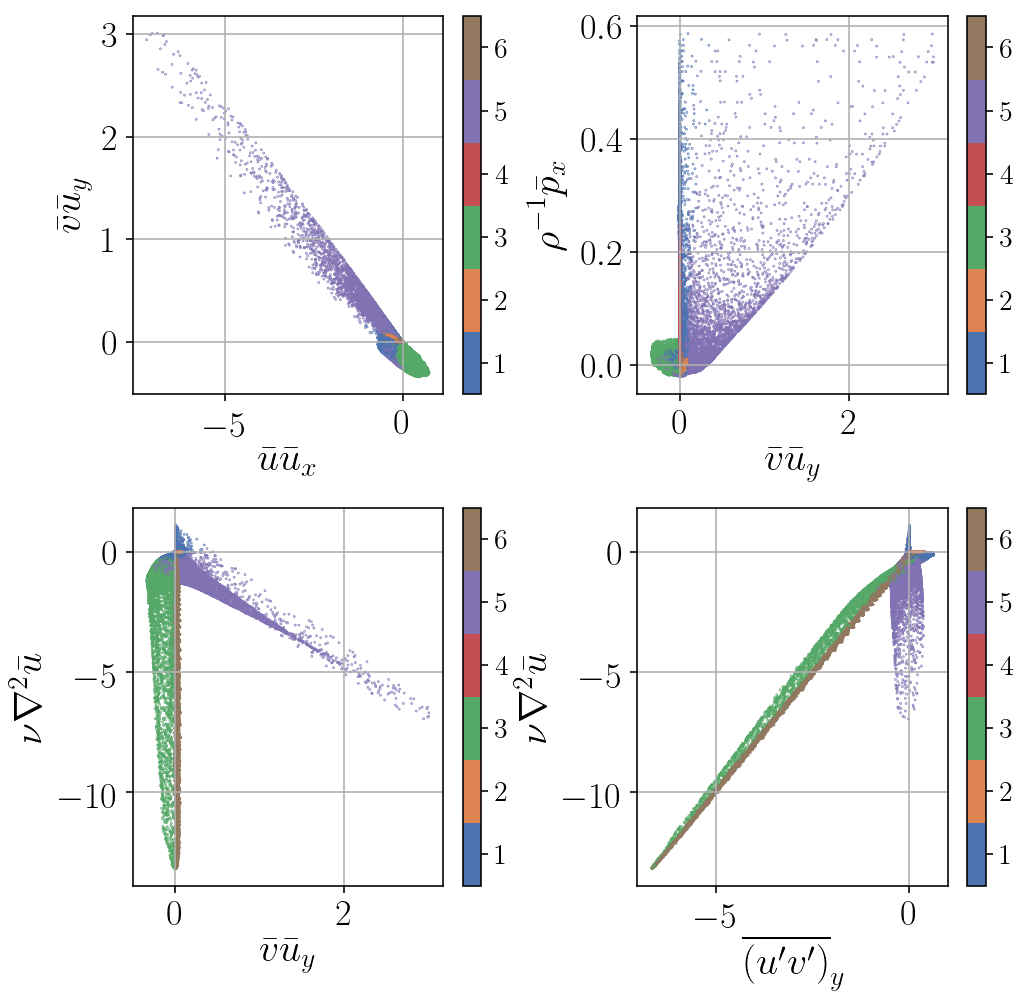

In [9]:
# Visualize GMM clustering with 2D views of equation space

cluster_idx = model.predict(features[mask, :])+1
clim = [.5, cm.N-0.5]
bounds = np.arange(0.5, nc+1.5)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.scatter(features[mask, 0], features[mask,1], .1, cluster_idx, cmap=cm)
plt.xlabel(labels[0], fontsize=20)
plt.ylabel(labels[1], fontsize=20)
plt.clim([-.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+1))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(222)
plt.scatter(features[mask, 1], features[mask,2], .1, cluster_idx, cmap=cm)
plt.xlabel(labels[1], fontsize=20)
plt.ylabel(labels[2], fontsize=20)
plt.clim([-.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+1))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)


plt.subplot(223)
plt.scatter(features[mask, 1], features[mask,3], .1, cluster_idx, cmap=cm)
plt.xlabel(labels[1], fontsize=20)
plt.ylabel(labels[3], fontsize=20)
plt.clim([-.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+1))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)


plt.subplot(224)
plt.scatter(features[mask, 4], features[mask,3], .1, cluster_idx, cmap=cm)
plt.xlabel(labels[4], fontsize=20)
plt.ylabel(labels[3], fontsize=20)
plt.clim([-.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+1))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
plt.show()

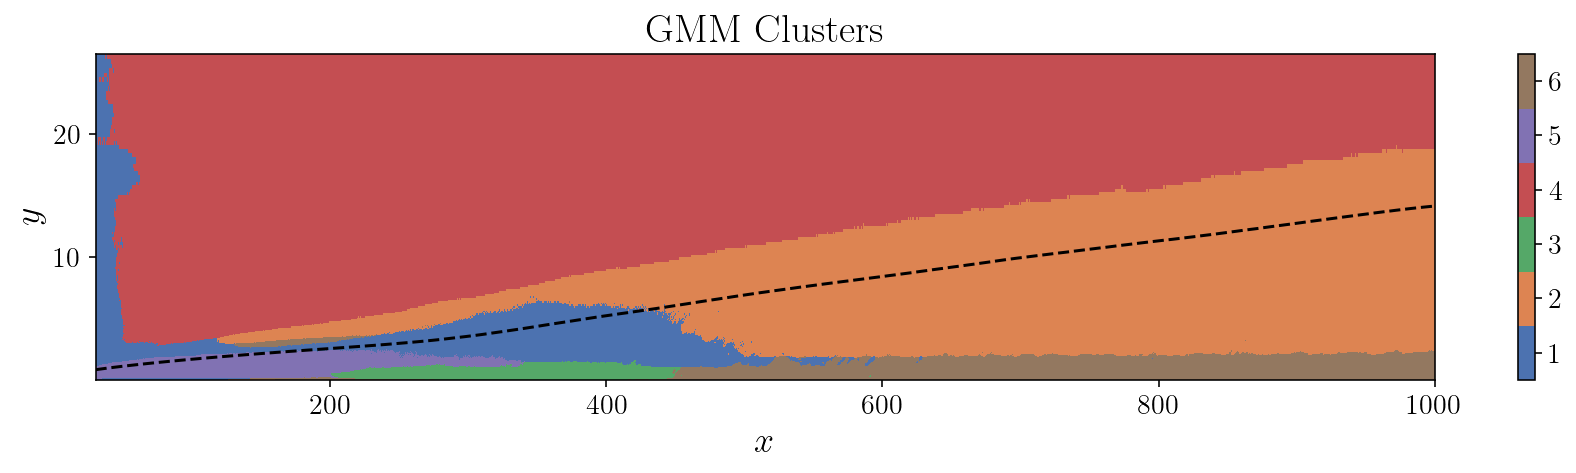

In [10]:
# "Predict" clusters in entire domain
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, [ny, nx], order='F')

# Colormap of clusters in entire domain
plt.figure(figsize=(15, 3))
plt.pcolor(x, y, clustermap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5)
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(0, nc+1))

plt.contour(X, Y, np.reshape(u/U_inf, [ny, nx], order='F'), [0.99], linestyles='dashed', colors='k')

plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18)
plt.title('GMM Clusters', fontsize=20)

plt.show()

# 3. SPCA reduction

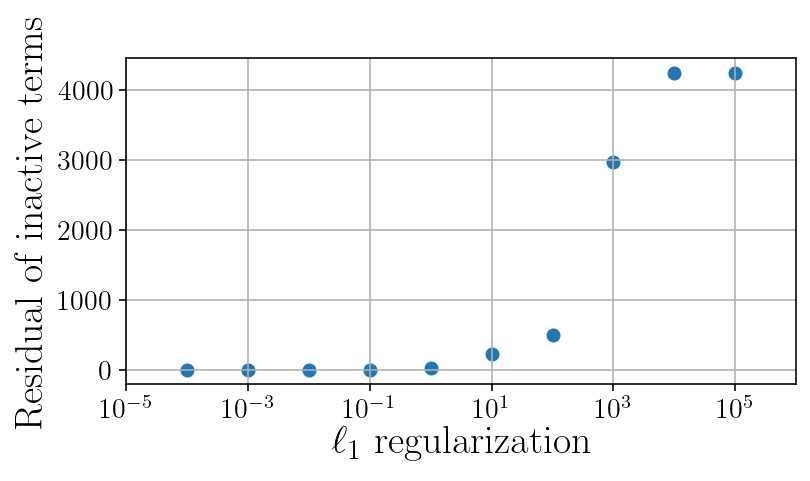

In [11]:
# Sparse PCA to identify directions of nonzero variance
#   First step: model selection for L1 regularization
alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        cluster_features = features[feature_idx, :]
        spca = SparsePCA(n_components=1, alpha=alphas[k], normalize_components=True)
        spca.fit(cluster_features)
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
    
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
        
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel(r'$\ell_1$ regularization')
plt.ylabel('Residual of inactive terms')
plt.gca().set_xscale('log')
plt.xlim([1e-5, 1e6])
plt.grid()
plt.show()

In [12]:
# Sparse PCA to identify directions of nonzero variance
alpha_opt = 10

spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :]
    spca = SparsePCA(n_components=1, alpha=alpha_opt, normalize_components=True)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    else: print('None')

GMM Cluster 0:
['$\\bar{u} \\bar{u}_x$', '$\\rho^{-1} \\bar{p}_x$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 1:
['$\\bar{u} \\bar{u}_x$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 2:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 3:
['$\\bar{u} \\bar{u}_x$', '$\\rho^{-1} \\bar{p}_x$']
GMM Cluster 4:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\rho^{-1} \\bar{p}_x$', '$\\nu \\nabla^2 \\bar{u}$']
GMM Cluster 5:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']


# 4. Final dominant balance models

In [13]:
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
    else: print('No dynamics')

# Make new cluster_idx based on SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order='F')


[[0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0. 0.]]
SPCA Cluster 0:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 1:
['$\\bar{u} \\bar{u}_x$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 2:
['$\\bar{u} \\bar{u}_x$', '$\\rho^{-1} \\bar{p}_x$']
SPCA Cluster 3:
['$\\bar{u} \\bar{u}_x$', '$\\rho^{-1} \\bar{p}_x$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 4:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\rho^{-1} \\bar{p}_x$', '$\\nu \\nabla^2 \\bar{u}$']


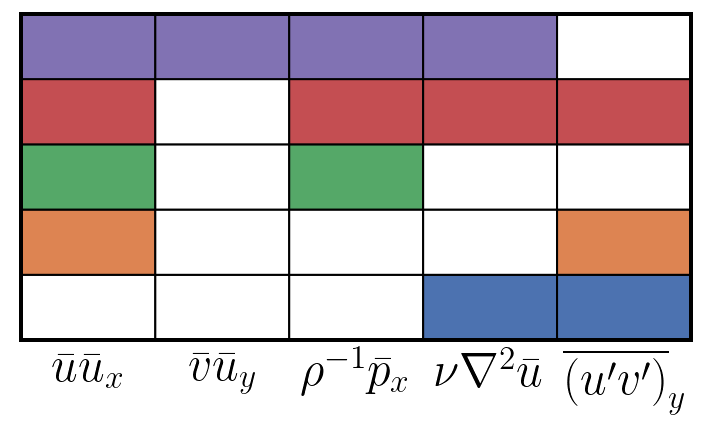

In [14]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap==0
gridmap = (gridmap.T*np.arange(nmodels)).T+1  # Scale map so that active terms can be color-coded
gridmap[gridmask] = 0

# Delete zero terms
grid_mask = np.nonzero( np.all(gridmap==0, axis=0) )[0]
gridmap = np.delete(gridmap, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)

plt.figure(figsize=(6, 3))
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k', linewidth=1)
plt.gca().set_xticks(np.arange(0.5, gridmap.shape[0]+0.5))
plt.gca().set_xticklabels(grid_labels, fontsize=24)
plt.gca().set_yticklabels([])
#plt.gca().set_yticks(np.arange(0.5, nmodels+0.5))
#plt.gca().set_yticklabels(range(nc), fontsize=20
#plt.ylabel('Balance Model')

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)

plt.gca().tick_params(axis='both', width=0)
plt.show()

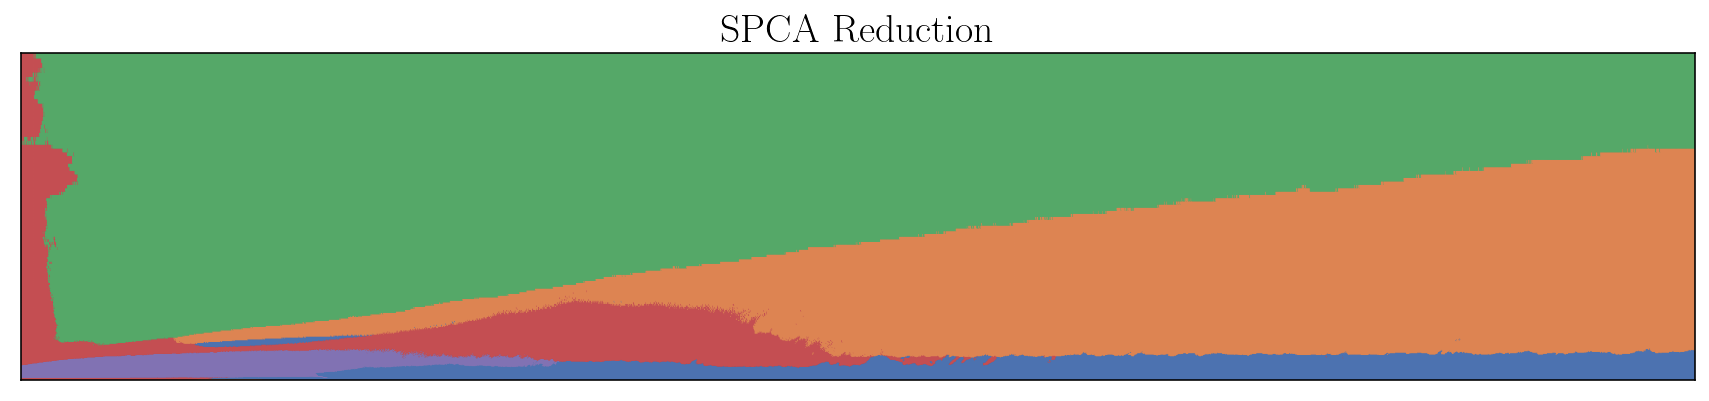

In [15]:

plt.figure(figsize=(15, 3))
plt.pcolor(x, y, balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, alpha=1, edgecolors='face')

plt.gca().set_xticks([])
plt.gca().set_yticks([])

#plt.xlabel('$x$')
#plt.ylabel('$y$')
plt.title('SPCA Reduction')

plt.show()

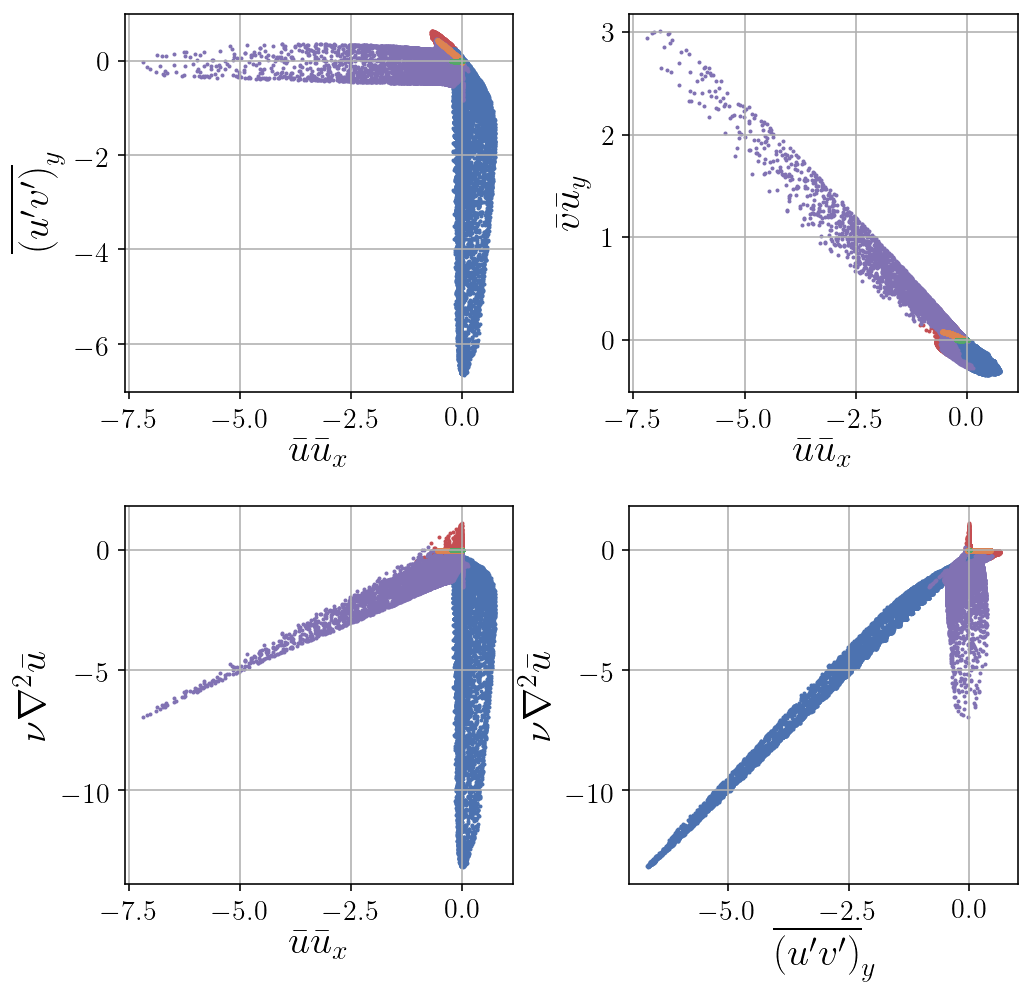

In [16]:
# Plot for figure 1

clim = [.5, cm.N-0.5]
bounds = np.arange(0.5, nmodels+1.5)
fontsize=20
s=1

# Plot order for best visibility
order = [3, 0, 4, 1, 2]

# 2D views of feature space
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for k in order:
    plt_mask = mask[ np.nonzero(balance_idx[mask]==k) ]
    c = np.array(cm(k+1))[None, :]
    ax[0, 0].scatter(features[plt_mask, 0], features[plt_mask,4], s=s, c=c)
    ax[0, 1].scatter(features[plt_mask, 0], features[plt_mask,1], s=s, c=c)
    ax[1, 0].scatter(features[plt_mask, 0], features[plt_mask,3], s=s, c=c)
    ax[1, 1].scatter(features[plt_mask, 4], features[plt_mask,3], s=s, c=c)

ax[0,0].set_xlabel(labels[0], fontsize=fontsize)
ax[0,0].set_ylabel(labels[4], fontsize=fontsize)

ax[0,1].set_xlabel(labels[0], fontsize=fontsize)
ax[0,1].set_ylabel(labels[1], fontsize=fontsize)

ax[1,0].set_xlabel(labels[0], fontsize=fontsize)
ax[1,0].set_ylabel(labels[3], fontsize=fontsize)

ax[1,1].set_xlabel(labels[4], fontsize=fontsize)
ax[1,1].set_ylabel(labels[3], fontsize=fontsize)

for i in [0, 1]:
    for j in [0, 1]:
        ax[i,j].grid()

        #ax[i,j].set_xticklabels([])
        #ax[i,j].set_yticklabels([])
        #ax[i,j].tick_params(axis='x', length=10, width=0)
        #ax[i,j].tick_params(axis='y', length=0)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

plt.show()

# Outer layer scaling

The length scale of the outer layer should scale with $ \ell \sim x^{4/5} $ (see pg 71 in Holmes, Lumley, Berkooz or pg 638 in Schlichting)

As a rough diagnostic of our balance model, define the outer layer length scale as the wall-normal coordinate where the balance changes from the inertial sublayer to the free-stream (once the transitional region has disappeared).

[0.06830149 0.81284353]


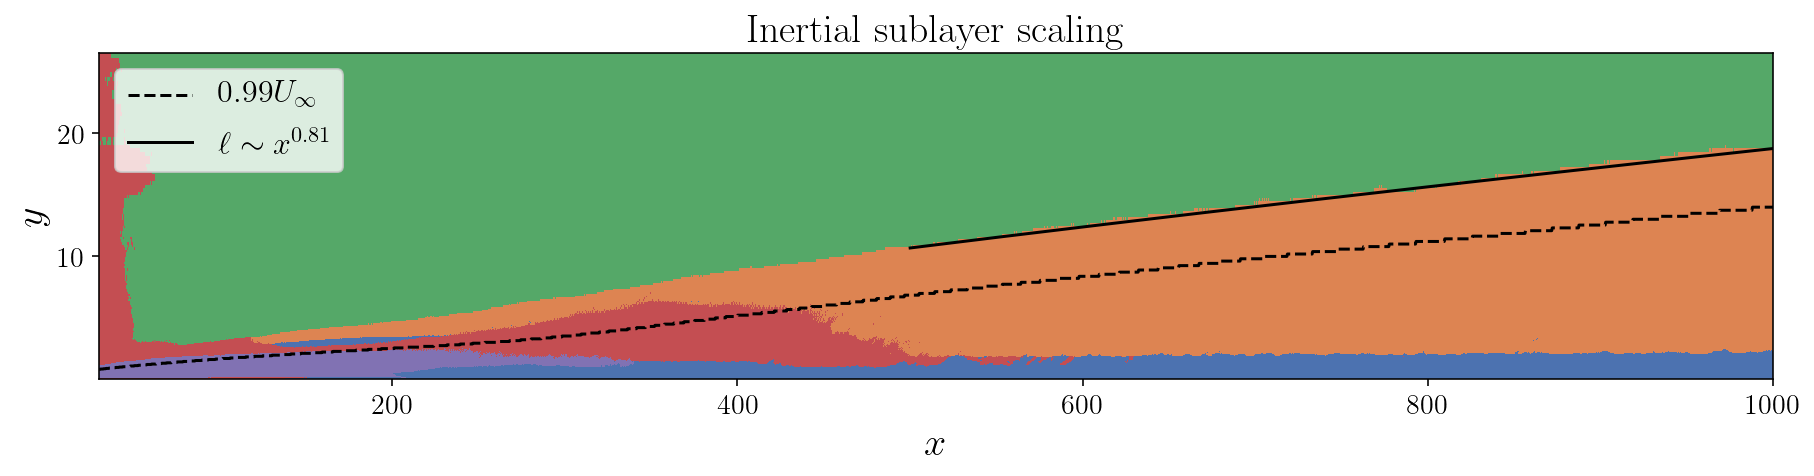

In [17]:
balancemap = np.reshape( balance_idx, (ny, nx), order='F')
u_map = np.reshape( u, (ny, nx), order='F' )

x_min = 110      # Where inertial balance begins
x_turb = 500    # Where transitional region ends

x_idx = np.nonzero(x > x_min)[0]
x_layer = x[x_idx]

# First, find upper extent of inertial sublayer
y_gmm = np.zeros(len(x_idx))  # Upper extent of inertial balance
for i in range(len(x_idx)):
    # Loop through wall-normal direction until the balance changes
    j = len(y)-1
    while balancemap[j, x_idx[i]] == 2:
        j -= 1
    y_gmm[i] = y[j]  # Store upper value of inertial balance
    
delta = np.zeros(len(x))  # 99% freestream contour
for i in range(len(x)):
    # Loop until velocity falls past 99% freestream
    j = 0
    while u_map[j, i] < 0.99:
        j += 1
    delta[i] = y[j-1]
    
# Fit inertial balance to power law
power_law = lambda x, a, b: a*x**b

to_fit = x_layer>x_turb  # When transitional region ends
p_gmm, cov = curve_fit(power_law, x_layer[to_fit], y_gmm[to_fit])
gmm_fit = power_law(x_layer, *p_gmm)
print(p_gmm)

plt.figure(figsize=(15, 3))
plt.pcolor(x, y, balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5)

plt.plot(x, delta, 'k--', label=r'$0.99 U_\infty$')  
plt.plot(x_layer[to_fit], gmm_fit[to_fit], 'k',
         label=r"$\ell \sim x^{{{0:0.2f}}}$".format(p_gmm[1]))  
plt.legend(fontsize=16)

plt.xlabel('$x$')
plt.ylabel('$y$')

plt.title('Inertial sublayer scaling')
plt.show()

# Self-similarity

In the near-wall region (viscous sublayer), we should be able to collapse the profiles using wall units $u^+$, $y^+$.
Here we show that this universality breaks down at approximately the same place where the identified viscous sublayer balance ends.

As shown in the figure above, the wall-normal extend of the sublayer (blue) is approximately constant in the fully-developed turbulent region. We show below that this corresponds to $y^+ \sim 70$.

70.52151160832888
73.82298516894761
72.21236885931181
77.9752753165163
80.48815827148658


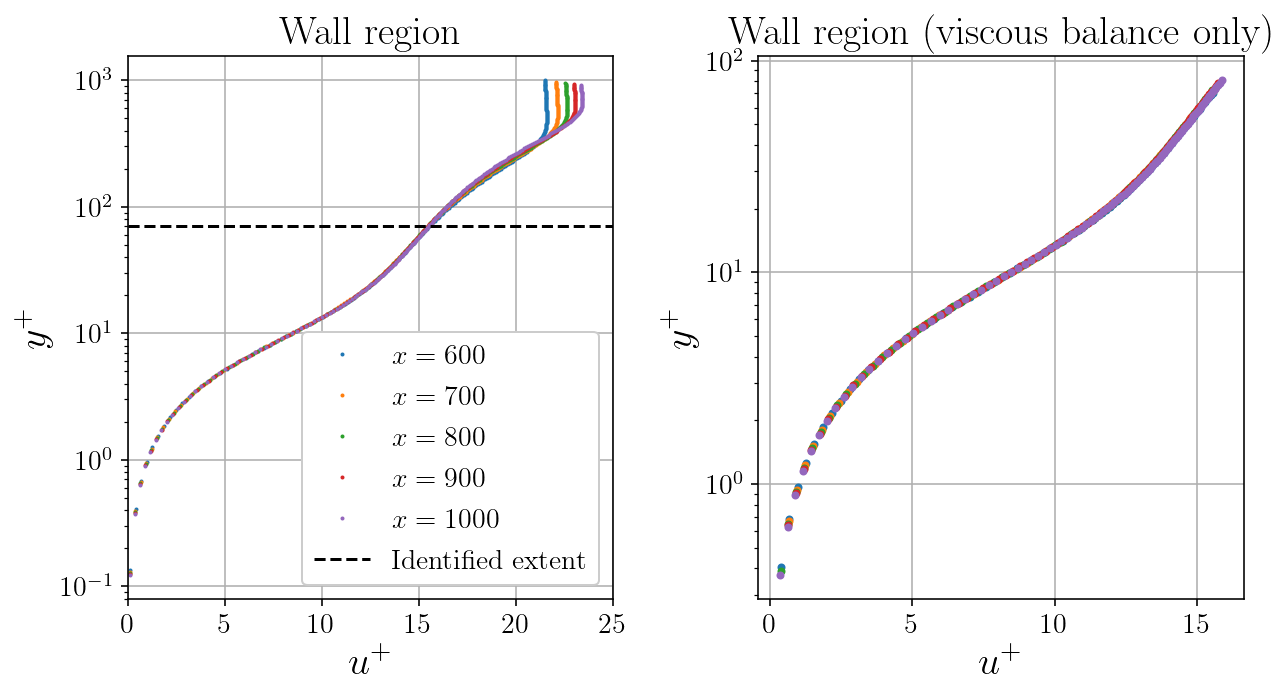

In [18]:
# Compute friction velocity with an estimate of wall shear stress
u_tau = np.sqrt(nu*uy[::ny])

y_plus = np.outer(y, u_tau/nu)
u_plus = np.reshape(u, [ny, nx], order='F')/u_tau

y_fit = []
u_fit = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
x_plt = [600, 700, 800, 900, x[-3]]
for i in range(len(x_plt)):
    x_idx = np.nonzero(x > x_plt[i])[0][0]
    
    # Find viscous balance indices
    y_idx = np.nonzero(balancemap[:, x_idx] == 0)[0]
    
    # Print the y+ coordinate where the balance ends (~70)
    print(y_plus[y_idx[-1], x_idx])
    
    ax1.plot(u_plus[:, x_idx], y_plus[:, x_idx], '.', markersize=2,
             label='$x={{{0:d}}}$'.format(int(np.round(x[x_idx]))))
    ax2.plot(u_plus[y_idx, x_idx], y_plus[y_idx, x_idx], '.',
             label='$x={{{0:d}}}$'.format(int(np.round(x[x_idx]))))
    
    y_fit = np.concatenate((y_fit, y_plus[y_idx, x_idx]))
    u_fit = np.concatenate((u_fit, u_plus[y_idx, x_idx]))

ax1.plot([0, 30], [70, 70], 'k--', label='Identified extent')
ax1.set_xlim([0, 25])
ax1.legend(fontsize=14, framealpha=1)

ax1.set_yscale('log')
ax1.set_ylabel('$y^+$')
ax1.set_xlabel('$u^+$')
ax1.set_title('Wall region')
ax1.grid()

ax2.set_yscale('log')
ax2.set_ylabel('$y^+$')
ax2.set_xlabel('$u^+$')
ax2.set_title('Wall region (viscous balance only)')

ax2.grid()

plt.subplots_adjust(wspace=0.3)
plt.show()

# Blasius solution in laminar regime

We also find that there is an inflow region without significant Reynolds stress (red), which suggests this flow is approximately laminar, until the transitional (orange) region begins around $x\sim 105$.  Before that we would expect the Blasius boundary layer solution to hold.

__Blasius solution:__
$$ \eta = y \sqrt{\frac{U}{2\nu x} }$$
$$ u = U f'(\eta) $$
[Wikipedia](https://en.wikipedia.org/wiki/Blasius_boundary_layer#Blasius_equation_-_first-order_boundary_layer)

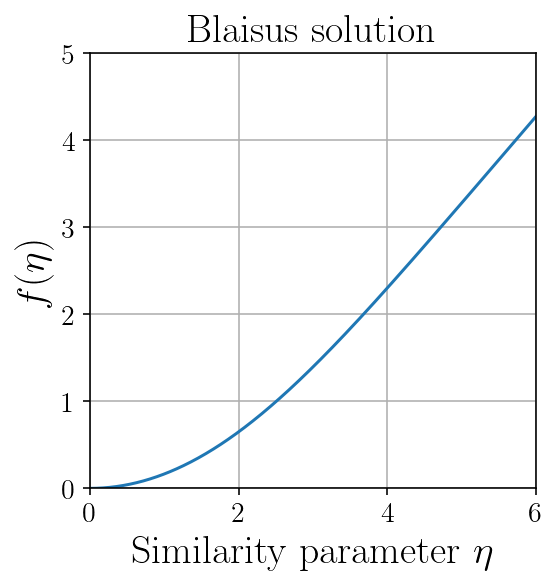

In [19]:
# Solve Blasius equations numerically

eta_inf = 200;  # Arbitrary "infinite" upper limit for domain
d_eta = 0.01;   # Step size
eta = np.arange(0, eta_inf, d_eta)

F_init = [0, 0, 0] # Initial guess for unknown initial condition

def blasius_rhs(f):
    """RHS of Blasius equation recast as first order nonlinear ODE
    f[0] = f
    f[1] = f'
    f[2] = f''
    """
    return np.array([f[1], f[2], -f[0]*f[2]/2])

def bc_fn(f0):
    """Solve with unknown initial condition as guess and evaluate at upper boundary"""
    global eta
    f = odeint(lambda f, t: blasius_rhs(f), f0, eta)
    # return discrepancy between upper boundary and desired f[2] = 1
    return [f0[0], f0[1], f[-1, 1] - 1]

# Solve root-finding problem for unknown initial condition
opt_res = root(bc_fn, F_init, tol=1e-4)
F0 = [0, 0, opt_res.x[2]]

# Evaluate with resulting initial conditions
f = odeint(lambda y, t: blasius_rhs(y), F0, eta)

plt.figure(figsize=(4, 4))
plt.plot(eta, f[:, 0], label='Scipy solution')
plt.xlabel(r'Similarity parameter $\eta$')
plt.ylabel(r'$f(\eta)$')
plt.xlim([0, 6])
plt.ylim([0, 5])
plt.grid()
plt.title('Blaisus solution')
plt.show()

Then we can compare the inflow profile to the Blasius solution (dotted lines indicate region where the transitional balance begins, after $x \sim 150$.  Until that point there is a maximum deviation of about 6% from the Blasius solution.

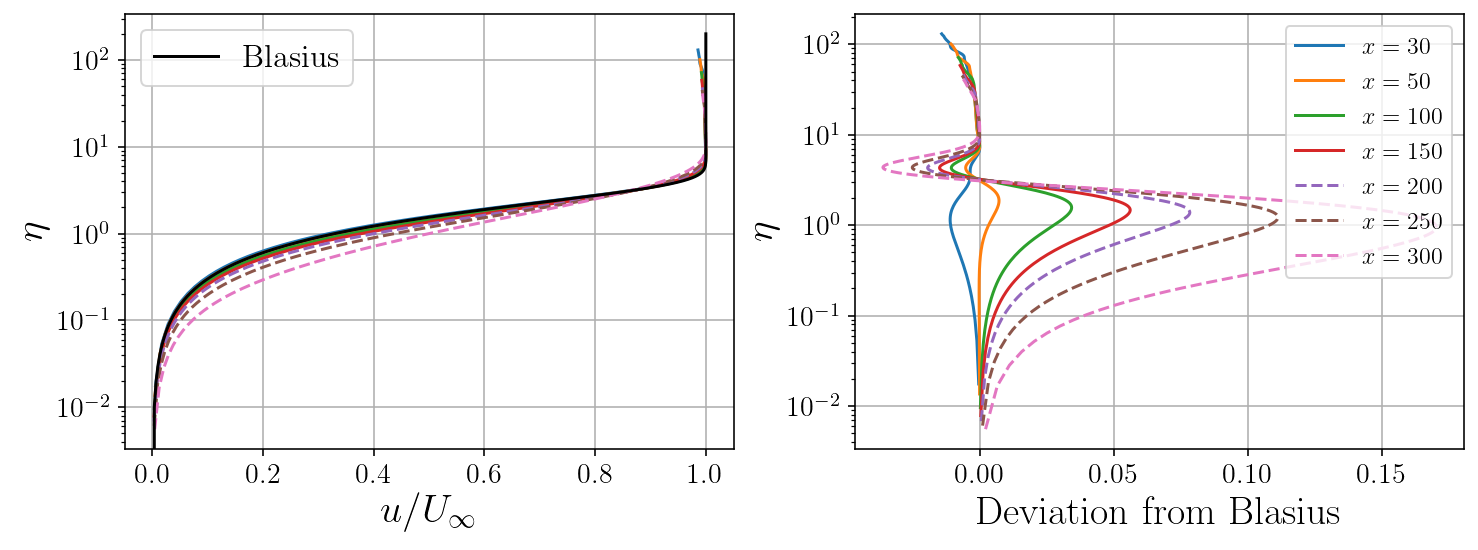

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
u_map = np.reshape(u, [ny, nx], order='F')

# Create a function of eta for f_prime
f_prime = interp1d(eta, f[:, 1])  # Second variable from first-order integrator

for x_plt in [30, 50, 100, 150, 200, 250, 300]:
    x_idx = np.nonzero(x > x_plt)[0][0]

    eta_plot = y*np.sqrt(U_inf/(1.1*nu*x_plt))

    dev = u_map[:, x_idx]/max(u_map[:, x_idx]) - f_prime(eta_plot) 
    if x_plt < 200:
        ax1.plot(u_map[:, x_idx]/max(u_map[:, x_idx]), eta_plot)
        ax2.plot(dev, eta_plot, label='$x={{{0}}}$'.format(x_plt))
    else:
        ax1.plot(u_map[:, x_idx]/max(u_map[:, x_idx]), eta_plot, '--')
        ax2.plot(dev, eta_plot, '--', label='$x={{{0}}}$'.format(x_plt))
    
#plt.ylim([0, 10])
ax1.plot(f[:, 1], eta, 'k', label='Blasius')
ax1.set_yscale('log')
ax1.legend(fontsize=16)

ax1.set_ylabel('$\eta$')
ax1.set_xlabel('$u/U_\infty$')
ax1.grid()


ax2.legend(fontsize=12)
ax2.set_yscale('log')

ax2.set_ylabel('$\eta$')
ax2.set_xlabel('Deviation from Blasius')
ax2.grid()
    
plt.show()
    